# GAN creation

In [6]:
# ! pip install matplotlib
# ! pip install Pillow imageio

In [7]:
# For COLAB
# from google.colab import drive
# drive.mount('/content/gdrive')
# !pip install -q kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download xhlulu/140k-real-and-fake-faces
# ! unzip 140k-real-and-fake-faces.zip

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

In [9]:
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, ReLU, LeakyReLU, Dropout, Conv2DTranspose, BatchNormalization, ZeroPadding2D, UpSampling2D, Activation, MaxPooling2D

In [10]:
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import array_to_img
from keras.callbacks import Callback

In [11]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 536047270735794496
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1733715559
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13601892055940340448
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [12]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Physical devices cannot be modified after being initialized


## Dataset loading

In [13]:
BATCH_SIZE = 32
image_height = 64
image_width = 64
latent_features = 100
num_images = 1000

In [14]:
# Define the input and output directories
input_directory = 'real_vs_fake/real-vs-fake/train'

# Create a dataset from the images
real_folder = os.path.join(input_directory, 'fake')
image_paths = [os.path.join(real_folder, filename) for filename in os.listdir(real_folder)[:num_images]]

# Function to preprocess the image
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_height, image_width], method=tf.image.ResizeMethod.GAUSSIAN)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

# Create a dataset from the image paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

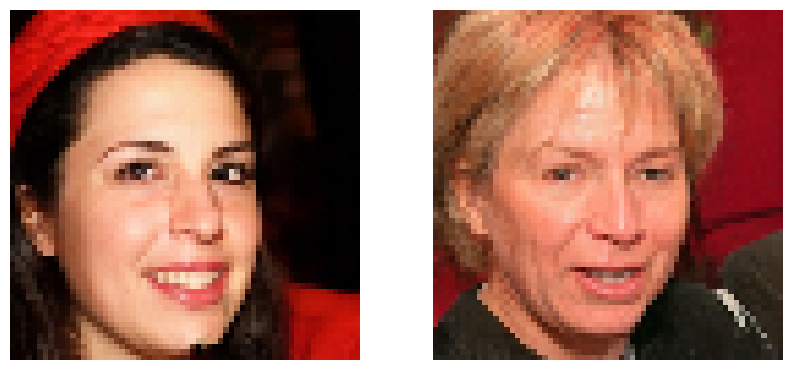

In [15]:
for batch in dataset.take(1):  # Take the first batch for display
    batch = (batch + 1) / 2
    plt.figure(figsize=(10, 10))
    for i in range(min(BATCH_SIZE, 2)):
        plt.subplot(2, 2, i + 1)
        plt.imshow(batch[i].numpy())
        plt.axis("off")
    plt.show()

In [16]:
len(dataset)

32

## GAN architecture

In [13]:
# from keras.initializers import RandomNormal
# from keras.models import Sequential
# from keras.layers import Conv2D, Dense, Flatten, Reshape, ReLU, LeakyReLU, Dropout, Conv2DTranspose, BatchNormalization, ZeroPadding2D, UpSampling2D, Activation, MaxPooling2D

In [12]:
def build_generator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Dense(2*2*1024, input_dim=latent_features, kernel_initializer=init))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((2,2,1024)))

    model.add(Conv2DTranspose(512, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(256, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(128, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(64, 4, 2,padding='same', kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', activation='tanh', kernel_initializer=init, use_bias=False))

    return model

generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        8388608   
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097152   
 ranspose)                                              

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


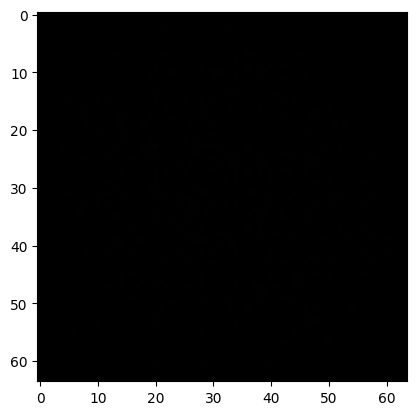

In [13]:
img = generator(np.random.normal(size=(1, latent_features, 1)))
plt.imshow(img[0])

In [14]:
def build_discriminator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Conv2D(64, 4, 2, padding='same', 
                     input_shape = (image_width,image_height,3), 
                     kernel_initializer=init, use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, 4, 2, padding='same', kernel_initializer=init, 
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, 4, 2, padding='same', kernel_initializer=init, 
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, 4, 2, padding='same', kernel_initializer=init, 
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(1024, 4, 2, padding='same', kernel_initializer=init, 
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(1024, 2, 1, kernel_initializer=init, 
                        use_bias=False))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)        

In [15]:
img = generator.predict(np.random.normal(size=(4, latent_features, 1)))
discriminator.predict(img)

1/1 [==============================] - 0s 108ms/step


array([[0.5000711 ],
       [0.50003576],
       [0.5000686 ],
       [0.5000281 ]], dtype=float32)

## Training loop

In [16]:
# from keras.models import load_model
# generator = load_model('models/generator.h5')
# discriminator = load_model('models/discriminator.h5')

In [14]:
# from keras.models import Model
# from keras.optimizers import Adam
# from keras.losses import BinaryCrossentropy
# from keras.utils import array_to_img
# from keras.callbacks import Callback

In [18]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            real_images = batch
            ypred_real = self.discriminator(real_images, training=True)
            y_real = tf.ones_like(ypred_real)
            # noise_real = -0.10*tf.random.uniform(tf.shape(ypred_real))
            # y_real += noise_real
            real_d_loss = self.d_loss(y_real, ypred_real)
        # dgrad = d_tape.gradient(real_d_loss, self.discriminator.trainable_variables)
        # self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # with tf.GradientTape() as d_tape:
            fake_images = self.generator(tf.random.normal((BATCH_SIZE, latent_features, 1)), training=False)
            ypred_fake = self.discriminator(fake_images, training=True)
            y_fake = tf.zeros_like(ypred_fake)
            # noise_fake = 0.10*tf.random.uniform(tf.shape(ypred_fake))
            # y_fake += noise_fake
            fake_d_loss = self.d_loss(y_fake, ypred_fake)

            total_d_loss = real_d_loss + fake_d_loss
        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((BATCH_SIZE,latent_features,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.ones_like(predicted_labels), predicted_labels)
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        # return {"d_loss":total_d_loss, "g_loss":total_g_loss}
        return {"d_loss":total_d_loss,"d_loss_real":real_d_loss,"d_loss_fake":fake_d_loss, "g_loss":total_g_loss}

In [19]:
d_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [20]:
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [21]:
class ModelMonitor(Callback):
    def __init__(self, latent_dim=latent_features):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            random_latent_vectors = tf.random.uniform((1, self.latent_dim,1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = (generated_images + 1) / 2
            generated_images = generated_images.numpy()
            img = array_to_img(generated_images[0])
            os.makedirs("training/", exist_ok=True)
            img.save(f'training/{epoch}_generated_img.png')
            os.makedirs("models/", exist_ok=True)
            generator.save('models/generator.keras',include_optimizer=True)
            discriminator.save('models/discriminator.keras',include_optimizer=True)


## Training

In [22]:
hist = gan.fit(dataset, epochs=500, callbacks=[ModelMonitor()])

Epoch 1/500
32/32 [==============================] - 6s 109ms/step - d_loss: 0.8208 - d_loss_real: 0.0680 - d_loss_fake: 0.7528 - g_loss: 0.7059
Epoch 2/500
32/32 [==============================] - 3s 94ms/step - d_loss: 0.8333 - d_loss_real: 0.0541 - d_loss_fake: 0.7792 - g_loss: 0.6956
Epoch 3/500
32/32 [==============================] - 3s 93ms/step - d_loss: 0.8154 - d_loss_real: 0.0511 - d_loss_fake: 0.7642 - g_loss: 0.7152
Epoch 4/500
32/32 [==============================] - 3s 92ms/step - d_loss: 0.8141 - d_loss_real: 0.0544 - d_loss_fake: 0.7598 - g_loss: 0.7226
Epoch 5/500
32/32 [==============================] - 3s 93ms/step - d_loss: 0.7944 - d_loss_real: 0.0414 - d_loss_fake: 0.7530 - g_loss: 0.7076
Epoch 6/500
32/32 [==============================] - 3s 97ms/step - d_loss: 0.7500 - d_loss_real: 0.0284 - d_loss_fake: 0.7216 - g_loss: 0.7206
Epoch 7/500
32/32 [==============================] - 3s 93ms/step - d_loss: 0.7804 - d_loss_real: 0.0446 - d_loss_fake: 0.7358 - g_loss

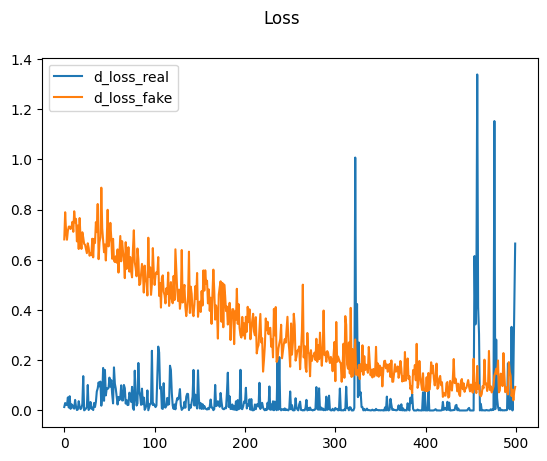

In [23]:
plt.suptitle('Loss')
# plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['d_loss_real'], label='d_loss_real')
plt.plot(hist.history['d_loss_fake'], label='d_loss_fake')
# plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [24]:
# Function to convert images to GIF
def convert_images_to_gif(input_folder, output_gif_path):
    images = []
    for filename in sorted(os.listdir(input_folder)):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)
            images.append(img)

    # Save images as GIF
    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration=200, loop=1)

# Example usage
input_folder = "training/"
output_gif_path = "training.gif"

convert_images_to_gif(input_folder, output_gif_path)

## Testing

In [17]:
from keras.models import load_model
generator = load_model("models/generator.keras")
discriminator = load_model("models/discriminator.keras")

generator.compile(optimizer=Adam(learning_rate=0.0002,beta_1=0.5),
                      loss=BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy()])
discriminator.compile(optimizer=Adam(learning_rate=0.0002,beta_1=0.5),
                      loss=BinaryCrossentropy(),metrics=[tf.keras.metrics.BinaryAccuracy()])

In [45]:
# For real images
for batch in dataset.take(1):
    print(discriminator.predict(batch, verbose=0))

[[0.99999976]
 [0.9999715 ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.9999989 ]
 [1.        ]
 [0.9999999 ]
 [1.        ]
 [1.        ]
 [0.99995863]
 [1.        ]
 [1.        ]
 [0.9999968 ]
 [0.9999989 ]
 [0.9999987 ]
 [1.        ]
 [0.999997  ]
 [0.99998534]
 [0.9999987 ]
 [1.        ]
 [1.        ]
 [0.9999994 ]
 [1.        ]
 [1.        ]
 [0.99999774]
 [0.9999999 ]
 [1.        ]
 [1.        ]
 [0.9995295 ]
 [1.        ]]


In [55]:
# For fake images
batch = generator.predict(tf.random.normal((BATCH_SIZE, latent_features, 1)),verbose=0)
results = discriminator.predict(batch, verbose=0)
print(results)

[[0.9981567 ]
 [0.1883584 ]
 [0.09341708]
 [0.0813118 ]
 [0.08488139]
 [0.33472502]
 [0.8242443 ]
 [0.40639192]
 [0.06706683]
 [0.78412205]
 [0.16497013]
 [0.14015004]
 [0.18066792]
 [0.08392666]
 [0.06592395]
 [0.11024669]
 [0.47670513]
 [0.1351099 ]
 [0.21609412]
 [0.06511557]
 [0.08052887]
 [0.09293654]
 [0.06865781]
 [0.30026376]
 [0.6223138 ]
 [0.08840097]
 [0.8154156 ]
 [0.50648665]
 [0.5317343 ]
 [0.22668166]
 [0.6962981 ]
 [0.3905324 ]]


## Discriminator testing

In [16]:
discriminator.evaluate(dataset)

32/32 [==============================] - 1s 18ms/step - loss: 0.0000e+00 - binary_accuracy: 0.0000e+00


[0.0, 0.0]

In [87]:
# Generating fake data
output_dir = "discriminator_data/fake"  # Directory to save generated images

# Load or create the generator model
# Example: generator_model = tf.keras.models.load_model('generator_model.h5')

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# Generate images using the generator model
generated_images = generator.predict(tf.random.normal((num_images, latent_features, 1)))

# Iterate over generated images and save them to disk
for i in range(num_images):
    image = generated_images[i]  # Get the generated image
    image = (image + 1) / 2
    image_path = os.path.join(output_dir, f"generated_image_{i}.jpg")  # Generate image file path
    tf.keras.preprocessing.image.save_img(image_path, image)  # Save the image to disk

print(f"{num_images} images generated and saved to {output_dir}.")


32/32 [==============================] - 0s 13ms/step
1000 images generated and saved to discriminator_data/fake.


In [94]:
output_dir = "discriminator_data/real"  # Directory to save images
batch_size = 32  # Batch size of the dataset

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate over the dataset and save images to disk
image_counter = 0
for batch in dataset:
    for image in batch:
        image = (image + 1) / 2
        image_path = os.path.join(output_dir, f"image_{image_counter}.jpg")
        tf.keras.preprocessing.image.save_img(image_path, image)
        image_counter += 1

print(f"All images saved to {output_dir}.")


All images saved to discriminator_data/real.


In [104]:
# Reading the images with the labels

dataset_dir = "discriminator_data"  # Directory containing the dataset
fake_dir = os.path.join(dataset_dir, "fake")  # Directory containing fake images
real_dir = os.path.join(dataset_dir, "real")  # Directory containing real images

# Function to read and preprocess images
def process_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_height, image_width], method=tf.image.ResizeMethod.GAUSSIAN)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

# Create a list of file paths for fake and real images
fake_file_paths = tf.data.Dataset.list_files(fake_dir + "/*.jpg")
real_file_paths = tf.data.Dataset.list_files(real_dir + "/*.jpg")

# Function to label the images
def label_fake_real(fake_path, real_path):
    return process_image(fake_path), 0, process_image(real_path), 1

# Combine fake and real datasets and label them accordingly
disc_dataset = tf.data.Dataset.zip((fake_file_paths, real_file_paths))
disc_dataset = disc_dataset.map(lambda fake_path, real_path: label_fake_real(fake_path, real_path))

# Optionally shuffle and batch the dataset
disc_dataset = disc_dataset.shuffle(buffer_size=1000)

# Optionally prefetch elements to improve performance
disc_dataset = disc_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# Iterate over the dataset (optional)
for batch in disc_dataset:
    fake_images, fake_labels, real_images, real_labels = batch
    # Process each batch as needed
    print("Fake Images:", fake_images.shape)
    print("Fake Labels:", fake_labels)
    print("Real Images:", real_images.shape)
    print("Real Labels:", real_labels)


Fake Images: (64, 64, 3)
Fake Labels: tf.Tensor(0, shape=(), dtype=int32)
Real Images: (64, 64, 3)
Real Labels: tf.Tensor(1, shape=(), dtype=int32)
Fake Images: (64, 64, 3)
Fake Labels: tf.Tensor(0, shape=(), dtype=int32)
Real Images: (64, 64, 3)
Real Labels: tf.Tensor(1, shape=(), dtype=int32)
Fake Images: (64, 64, 3)
Fake Labels: tf.Tensor(0, shape=(), dtype=int32)
Real Images: (64, 64, 3)
Real Labels: tf.Tensor(1, shape=(), dtype=int32)
Fake Images: (64, 64, 3)
Fake Labels: tf.Tensor(0, shape=(), dtype=int32)
Real Images: (64, 64, 3)
Real Labels: tf.Tensor(1, shape=(), dtype=int32)
Fake Images: (64, 64, 3)
Fake Labels: tf.Tensor(0, shape=(), dtype=int32)
Real Images: (64, 64, 3)
Real Labels: tf.Tensor(1, shape=(), dtype=int32)
Fake Images: (64, 64, 3)
Fake Labels: tf.Tensor(0, shape=(), dtype=int32)
Real Images: (64, 64, 3)
Real Labels: tf.Tensor(1, shape=(), dtype=int32)
Fake Images: (64, 64, 3)
Fake Labels: tf.Tensor(0, shape=(), dtype=int32)
Real Images: (64, 64, 3)
Real Labels: 

In [108]:
disc_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None), TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [103]:
# Define the size of the training and testing sets
train_size = int(0.8 * len(disc_dataset))  # 80% of the dataset for training
test_size = len(disc_dataset) - train_size  # Remaining 20% for testing

# Shuffle the dataset
dataset_shuffled = dataset.shuffle(buffer_size=len(disc_dataset))

# Split the dataset into training and testing sets
train_dataset = dataset_shuffled.take(train_size)
test_dataset = dataset_shuffled.skip(train_size).take(test_size)

Epoch 1/100


ValueError: in user code:

    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\sanya\Documents\AI image detection research\generated-image-detection\.env-gpu\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(None, None, 64, 64, 3)


In [102]:
disc_history = discriminator.fit(train_dataset,epochs=100,validation_split=.2)

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.data.ops.dataset_ops.TakeDataset'>]